请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

# NLI2STS迁移学习实验

In [1]:
import paddle
import paddlenlp
import json
import paddle.nn as nn
import numpy as np
import jieba
import time
import os
import paddle.nn.functional as F
from functools import partial
from paddlenlp.embeddings import TokenEmbedding
from paddlenlp.data import JiebaTokenizer
from paddlenlp.data import Stack, Tuple, Pad, Dict
from paddle.io import Dataset
from tqdm import tqdm
from paddlenlp.data import JiebaTokenizer
from sklearn.metrics import f1_score
from paddlenlp import seq2vec #编码器

## 参数类

In [2]:
#{'entailment': 16779, 'neutral': 17182, 'contradiction': 16476}
#data_num=1k;5k;10k
class parameters_dict():
    def __init__(self,lr=5e-5,max_epoch=15,batch_size=128,encoder_dim=400,embedding_dim=300,class_dim=3,\
    encoder="Bert",eval_step=200,log_step=70,dropout_p=0.4,data_savepath='data_save/1k/',weight_decay=0.000,data_num=16000):
        self.lr=lr
        self.max_epoch=max_epoch
        self.batch_size=batch_size
        self.encoder_dim=encoder_dim
        self.encder=encoder
        self.eval_step=eval_step
        self.log_step=log_step
        self.dropout_p=dropout_p
        self.data_savepath=data_savepath
        self.embedding_dim=embedding_dim
        self.class_dim=class_dim
        self.weight_decay=weight_decay
        self.data_num=data_num

parameters=parameters_dict()

## NLI数据预处理

In [3]:
'''!unzip data/data143287/ocnli_public.zip -d data/'''

'!unzip data/data143287/ocnli_public.zip -d data/'

## 构建数据加载类

In [4]:
#加载与预训练的Bert模型
from paddlenlp.transformers import BertModel,BertTokenizer

#加载预训练的Bert模型
tokenizer_bert = BertTokenizer.from_pretrained('bert-wwm-chinese')
bert_encode = BertModel.from_pretrained('bert-wwm-chinese')

[2022-05-02 12:17:56,564] [    INFO] - Found /home/aistudio/.paddlenlp/models/bert-wwm-chinese/bert-wwm-chinese-vocab.txt
[2022-05-02 12:17:56,580] [    INFO] - Already cached /home/aistudio/.paddlenlp/models/bert-wwm-chinese/bert-wwm-chinese.pdparams
W0502 12:17:56.583901  5942 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0502 12:17:56.588887  5942 device_context.cc:465] device: 0, cuDNN Version: 7.6.


In [5]:

def for_Bert_transfunc(sample,tokenizer,max_seq_length=512):
    query=sample['sentence1']
    title=sample['sentence2']
    encoded_inputs = tokenizer(
        text=query, text_pair=title, max_seq_len=max_seq_length)
    if 'label' in sample.keys():
        #注意将label进行转换
        encoded_inputs['label']=np.array(sample['label'],dtype="float32")
    return encoded_inputs

bert_transfunc=partial(for_Bert_transfunc,tokenizer=tokenizer_bert,max_seq_length=512)

In [6]:
class Dataset(paddle.io.Dataset):
    def __init__(self,data_path='data/data/',mode='train',data_num=50480,trans_fun=None,word_embeding_func=None,if_offline_to_id=False):
        super(Dataset, self).__init__()
        self.data=[]
        self.mode=mode
        self.trans_func=trans_fun
        self.word_embedding_func=word_embeding_func
        self.if_offline_to_id=if_offline_to_id
        #定义转换函数，将文本语言转换为bert的token_id便于输入
        self.label2int={'entailment':0,'contradiction':1,'neutral':2}
        #读取数据
        data_path=data_path+self.mode+'.json'
        count={'entailment':0,'neutral':0,'contradiction':0}
        with open(data_path,'r',encoding='utf-8') as f:
            for line in tqdm(f.readlines()):
                d=json.loads(line)
                #保留在句子和label即可：
                samp=dict()
                samp['sentence1']=d['sentence1']
                samp['sentence2']=d['sentence2']
                label=self.label2int.get(d['label'],-1)
                if label==-1:
                    continue
                samp['label']=label
                if d['label']=='entailment' and count['entailment']<data_num:
                    count['entailment']+=1
                    self.data.append(samp)
                elif d['label']=='neutral' and count['neutral']<data_num:
                    count['neutral']+=1
                    self.data.append(samp)
                elif d['label']=='contradiction' and count['contradiction']<data_num: 
                    count['contradiction']+=1
                    self.data.append(samp)
        f.close()
        print(count)
    
    def __getitem__(self,index,cut_embedding='cut'):
        #更具具体需求返回分词与否、词嵌入与否的数据
        if self.if_offline_to_id:
            cut_embedding='no'
        if cut_embedding == 'all':
            sample=self.data[index]
            #print(sample)
            #分词去停词
            sample_words=self.trans_func(sample)
            #进行词嵌入
            sample_embedding=dict()
            sample_embedding['sentence1']=self.word_embedding_func(sample_words['sentence1'])
            sample_embedding['sentence2']=self.word_embedding_func(sample_words['sentence2'])
            if 'label' in sample.keys():
                sample_embedding['label']=sample_words['label']
            return sample_embedding
        elif cut_embedding=='cut':
            sample=self.data[index].copy()
            #分词去停词，返回句子ID
            sample_words=self.trans_func(sample)
            return sample_words
        else:#cut_embedding=='no'
            sample=self.data[index]
            return sample

    def __len__(self):
        return len(self.data)

In [7]:
test_dataset=Dataset(data_path='data/',mode='train.50k',data_num=parameters.data_num,trans_fun=bert_transfunc)
print('原始数据：')
print(test_dataset.__getitem__(0,cut_embedding='no'))
print('分词、转换为token_id的对应数据：')
print(test_dataset.__getitem__(0,cut_embedding='cut'))
print(test_dataset.__len__())

100%|██████████| 50486/50486 [00:00<00:00, 110765.97it/s]


{'entailment': 16000, 'neutral': 16000, 'contradiction': 16000}
原始数据：
{'sentence1': '一月份跟二月份肯定有一个月份有.', 'sentence2': '肯定有一个月份有', 'label': 0}
分词、转换为token_id的对应数据：
{'input_ids': [101, 671, 3299, 819, 6656, 753, 3299, 819, 5507, 2137, 3300, 671, 702, 3299, 819, 3300, 119, 102, 5507, 2137, 3300, 671, 702, 3299, 819, 3300, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'label': array(0., dtype=float32)}
48000


### 数据加载类构建

In [8]:
#构建数据加载器
def create_dataloader(dataset, mode='train',batch_size=1,batchify_fn=None):
    shuffle = True if mode == 'train' else False
    if mode == 'train':
        batch_sampler = paddle.io.DistributedBatchSampler(
            dataset, batch_size=batch_size, shuffle=shuffle)
    else:
        batch_sampler = paddle.io.BatchSampler(
            dataset, batch_size=batch_size, shuffle=shuffle)
    return paddle.io.DataLoader(dataset=dataset,batch_sampler=batch_sampler,collate_fn=batchify_fn,return_list=True)

#整合Batch的数据
#需要根据是否使用Bert进行调整：非Bert返回token-id，Bert则需返回token-id\token_type等为字典。
def collate_func(batch_data,if_bert=False,max_length=512,tokenizer=None):
    batch_size = len(batch_data)
    # 如果batch_size为0，则返回一个空字典
    if batch_size == 0:
        return {}
    sentence1_list,sentence2_list,label_list=[],[],[]
    input_ids,token_type_ids=[],[]
    #判断是否是预测数据
    instance1=batch_data[1]
    is_test=1
    if 'label' in instance1.keys():
        is_test=0
    for instance in batch_data:
        if if_bert:
            token_type_id=instance['token_type_ids']
            input_id=instance['input_ids']
            input_ids.append(paddle.to_tensor(input_id, dtype="int64"))
            token_type_ids.append(paddle.to_tensor(token_type_id, dtype="int64"))
        else:
            sentence1=instance["sentence1"]
            sentence2=instance["sentence2"]
            #由于是token-id因此返回的是int64形
            sentence1_list.append(paddle.to_tensor(sentence1, dtype="int64"))
            sentence2_list.append(paddle.to_tensor(sentence2, dtype="int64"))
        if is_test==0:
            label=instance['label']
        if is_test==0:
            label_list.append(label)
    # 对一个batch内的数据，进行padding,padding的值为词表中的[pad]的Index:635964
    if if_bert:
        if is_test==0:
            return {'input_ids':Pad(axis=0, pad_val=tokenizer.pad_token_id,pad_right=False)(input_ids),  # input_ids
                'token_type_ids':Pad(axis=0, pad_val=tokenizer.pad_token_type_id,pad_right=False)(token_type_ids),
                "labels":Stack(dtype="int64")(label_list),
                }
        else:
            return {'input_ids':Pad(axis=0, pad_val=tokenizer.pad_token_id,pad_right=False)(input_ids),
                'token_type_ids':Pad(axis=0, pad_val=tokenizer.pad_token_type_id,pad_right=False)(token_type_ids),
                }
    else:
        if is_test==0:
            return {"sentence1s": Pad(pad_val=10218, axis=0,pad_right=False)(sentence1_list),
                "sentence2s": Pad(pad_val=10218, axis=0,pad_right=False)(sentence2_list),
                "labels": Stack(dtype="int64")(label_list),
                }
        else:
            return {"sentence1s": Pad(pad_val=10218, axis=0,pad_right=False)(sentence1_list),
                "sentence2s": Pad(pad_val=10218, axis=0,pad_right=False)(sentence2_list),
                }
collate_function=partial(collate_func,if_bert=True,tokenizer=tokenizer_bert)

In [9]:
#测试数据
batch_size=parameters.batch_size
test_data_loader = create_dataloader(test_dataset,mode='train',batch_size=128,batchify_fn=collate_func)
print(test_dataset.__len__()//batch_size)

375


## 构建模型

In [10]:
class Classifer(nn.Layer):
    def __init__(self,encoder=parameters.encder,embedding_dim=parameters.encoder_dim,\
                encoder_dim=parameters.encoder_dim,\
                class_dim=parameters.class_dim,\
                token_embedding=None,is_pre_embedding=False,mode='Bert',init_scale=0.1,is_embedding=False):
        #参数分别的意义：编码器、词嵌入维度、编码维度、分类数目、是否进行词嵌入、词嵌入的词表、是否使用预训练词嵌入、编码器名称、词嵌入层初始化、词表大小
        super(Classifer,self).__init__()
        print('使用的编码器是：'+mode)
        self.is_pre_embedding=is_pre_embedding
        self.is_embedding=is_embedding
        self.embedding_dim=embedding_dim
        self.encoder_dim=encoder_dim
        self.mode=mode
        self.encoder=encoder
        if self.is_pre_embedding and self.is_embedding:
            #构建预训练的词嵌入层
            print('使用预训练的词嵌入')
            pretrained_attr = paddle.ParamAttr(
                                   initializer=paddle.nn.initializer.Assign(token_embedding),
                                   trainable=False)
            self.embedding_layer=nn.Embedding(num_embeddings=token_embedding.shape[0],
                                      embedding_dim=token_embedding.shape[1],
                                      weight_attr=pretrained_attr)
        elif self.is_embedding:
            #使用非预训练的词嵌入层
            print('使用非预训练的词嵌入，训练词嵌入层')
            self.embedding_layer=nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, sparse=False, 
                                    weight_attr=paddle.ParamAttr(initializer=nn.initializer.Uniform(low=-init_scale, high=init_scale)))
                                    
        if self.mode!='Bert' and self.mode!="Ernie":
            self.fnn=nn.Sequential(nn.Linear(in_features=2*self.encoder_dim,out_features=400),nn.ReLU(),\
                    nn.Linear(in_features=400,out_features=class_dim))
            print('使用普通的Embedding层')

        else:
            self.fnn=nn.Sequential(nn.Linear(in_features=self.encoder.config["hidden_size"],out_features=400),nn.ReLU(),\
                    nn.Linear(in_features=400,out_features=class_dim))
            print('使用Transformer-based model')
        
    def forward(self,input_data):
        first_sentence_id,second_sentence_id=input_data[0],input_data[1]
        #如果不是Bert,那么直接就是输入词向量或者token-id
        #对于Bert编码器，两个sentence_id对应的是各自句子的Bert：input_id和token_type_id，需要进一步处理转换为Bert的输入，且使用Bert时，不需要embedding。
        if self.is_embedding:
            #进行词嵌入
            first_sentence=self.embedding_layer(first_sentence_id)
            second_sentence=self.embedding_layer(second_sentence_id)
        else:
            first_sentence=first_sentence_id
            second_sentence=second_sentence_id
        #计算编码
        if self.mode=='Bert' or self.mode=='Ernie':
            (sequence_output,cls)=self.encoder(input_ids=first_sentence,\
                                    token_type_ids=second_sentence)
            #得到的CLS就可以用于文本分类
            input_v=cls
            out=self.fnn(input_v)
            return out
        
        elif self.mode=='Transformer':
            code1=self.encoder(first_sentence)
            code2=self.encoder(second_sentence)
            #合并向量：
            input_v=paddle.concat(x=[code1,code2], axis=-1)
            out=self.fnn(input_v)
            return out
        elif  self.mode=='LSTM_API':
            seq_len1=paddle.to_tensor([first_sentence.shape[1] for i in range(first_sentence.shape[0])])
            seq_len2=paddle.to_tensor([second_sentence.shape[1] for i in range(second_sentence.shape[0])])
            code1=self.encoder(first_sentence,seq_len1)
            code2=self.encoder(second_sentence,seq_len2)
            #合并向量：
            input_v=paddle.concat(x=[code1,code2], axis=-1)
            out=self.fnn(input_v)
            return out

In [11]:
def evaluate(model, criterion, metric, data_loader):
    model.eval()
    metric.reset()
    losses = []
    acces=[]
    f1score=[]
    mode=model.mode
    for sample in data_loader:
        if mode=="Bert" or mode=='Ernie':
            sentence1=sample['input_ids']
            sentence2=sample['token_type_ids']
        else:
            sentence1=sample['sentence1s']
            sentence2=sample['sentence2s']
        labels=sample['labels']
        input_data=[sentence1,sentence2]
        logits = model(input_data)
        loss = criterion(logits, labels)
        losses.append(loss.numpy())
        logits = F.softmax(logits, axis=1)
        correct = metric.compute(logits, labels)
        #f1分数
        y_pred=np.argmax(logits.numpy(),axis=-1)
        y_ture=labels.numpy()
        f1=f1_score(y_pred=y_pred,y_true=y_ture,average='macro')
        f1score.append(f1)
        metric.update(correct)
        accu = metric.accumulate()
    print("eval loss: %.5f, accu: %.5f,f1:%.5f" % (np.mean(losses),accu,np.mean(f1score)))
    model.train()
    metric.reset()
    #返回验证的损失和准确率便于数据展示
    return (np.mean(losses), accu,np.mean(f1score))

In [12]:
def do_train( model, data_loader,  vali_data_loader, criterion,  optimizer,metric , scheduler=None  ):
    #paddle.set_device('gpu:0')
    model.train()
    global_step = 0

    tic_train = time.time()
    num_train_epochs=parameters.max_epoch
    log_steps=parameters.log_step
    #log_steps=1
    mode=model.mode#使用的编码器
    eval_step=parameters.eval_step
    #eval_step=20
    best_acc=0.73
    best_f1=0.74
    train_loss,train_acc,train_f1,train_iters=[],[],[],[]
    eval_loss,eval_acc,eval_iters,eval_f1=[],[],[],[]
    for epoch in range(num_train_epochs):
        for step,sample in enumerate(data_loader):
            if mode=="Bert" or mode=='Ernie':
                sentence1=sample['input_ids']
                #print('inputid:',sentence1.shape)
                sentence2=sample['token_type_ids']
                #print('tokrn_type',sentence2)
            else:
                sentence1=sample['sentence1s']
                sentence2=sample['sentence2s']
            truelabels=sample['labels']
            #print(truelabels)
            #print(type(sentence1))
            input_data=[sentence1,sentence2]
            outputs = model(input_data)
            #print(outputs.shape)
            #计算损失
            loss = criterion(outputs, truelabels)
            #print(loss)
            outputs = F.softmax(outputs, axis=1)
            correct = metric.compute(outputs, truelabels)
            metric.update(correct)
            acc = metric.accumulate()
            #f1分数
            y_pred=np.argmax(outputs.numpy(),axis=-1)
            y_ture=truelabels.numpy()
            f1=f1_score(y_pred=y_pred,y_true=y_ture,average='macro')
            #反向传播
            loss.backward()
            global_step += 1
            # 每间隔 log_steps 输出训练指标
            if global_step % log_steps == 0:
                print("global step %d, epoch: %d, batch: %d, loss: %.5f, accuracy: %.5f,F1-score:%.5f, speed: %.2f step/s"
                % (global_step, epoch, step, loss, acc,f1,
                    log_steps / (time.time() - tic_train)))
                train_iters.append(global_step)
                train_acc.append(acc)
                train_f1.append(f1)
                train_loss.append(loss.numpy())
            if global_step%eval_step==0 :
                evalloss,evalacc,evalf1=evaluate(model, criterion, metric, vali_data_loader)
                eval_acc.append(evalacc)
                eval_loss.append(evalloss)
                eval_f1.append(evalf1)
                eval_iters.append(global_step)
                if evalf1>best_f1 and evalacc>best_acc:
                    save_path='bert'+str(evalf1)+'.pdparams'
                    paddle.save(model.state_dict(),save_path)
                    best_acc=evalacc
                    best_f1=evalf1
                    print(evalf1,evalacc)
            #优化器迭代一步
            optimizer.step()
            optimizer.clear_grad()
            if scheduler:
                scheduler.step()
        metric.reset()
    #save_path=parameters.data_savepath+parameters.encder+'fc_finall.pdparams'
    #paddle.save(model.state_dict(),save_path)
    return (train_loss,train_acc,train_f1,train_iters),(eval_loss,eval_acc,eval_f1,eval_iters)

### 定义模型并进行训练

#### 加载数据集

In [13]:
train_ds=Dataset(data_path='data/',mode='train.50k',trans_fun=bert_transfunc,data_num=parameters.data_num)
eval_ds=Dataset(data_path='data/',mode='dev',trans_fun=bert_transfunc)
print('训练集大小：',train_ds.__len__())
print('验证集大小：',eval_ds.__len__())
#print('测试集大小：',test_ds.__len__())
train_data_loader = create_dataloader(train_ds,mode='train',batch_size=parameters.batch_size,batchify_fn=collate_function)
eval_data_loader = create_dataloader(eval_ds,mode='dev',batch_size=parameters.batch_size,batchify_fn=collate_function)
#test_data_loader = create_dataloader(test_ds,mode='test',batch_size=batch_size,batchify_fn=collate_fun)
print('Batch_size:',parameters.batch_size)
print('训练一轮步数：',train_ds.__len__()//parameters.batch_size)
parameters.log_step=int(train_ds.__len__()//parameters.batch_size//2)
parameters.eval_step=parameters.log_step*3
print(parameters.log_step)
print(parameters.eval_step)

100%|██████████| 50486/50486 [00:00<00:00, 141826.98it/s]


{'entailment': 16000, 'neutral': 16000, 'contradiction': 16000}
{'entailment': 947, 'neutral': 1103, 'contradiction': 900}
训练集大小： 48000
验证集大小： 2950
Batch_size: 128
训练一轮步数： 375
187
561


100%|██████████| 3000/3000 [00:00<00:00, 144805.94it/s]


#### 定义模型

In [14]:
model=Classifer(encoder=bert_encode,is_embedding=False,mode='Bert')
#pre_trained_dict=paddle.load('data/data143410/Bert0.5676.pdparams')
#model.set_state_dict(pre_trained_dict)
#打印网络查看网络结构
params_info = paddle.summary(model, (2, 64,5),dtypes='int64')
print(params_info)

使用的编码器是：Bert
使用Transformer-based model
--------------------------------------------------------------------------------------------------------------------------------
       Layer (type)                               Input Shape                              Output Shape            Param #    
       Embedding-1                                 [[64, 5]]                               [64, 5, 768]          16,226,304   
       Embedding-2                                 [[64, 5]]                               [64, 5, 768]            393,216    
       Embedding-3                                 [[64, 5]]                               [64, 5, 768]             1,536     
       LayerNorm-1                              [[64, 5, 768]]                             [64, 5, 768]             1,536     
        Dropout-1                               [[64, 5, 768]]                             [64, 5, 768]               0       
     BertEmbeddings-1                                 []              

#### 定义优化器和学习准则

In [15]:

#定义损失函数：交叉熵损失
criterion=nn.loss.CrossEntropyLoss()
#定义优化器
from paddlenlp.transformers import LinearDecayWithWarmup
num_training_steps = len(train_data_loader) *parameters.max_epoch
lr_scheduler = LinearDecayWithWarmup(parameters.lr, num_training_steps, 0.0)
decay_params = [
    p.name for n, p in model.named_parameters()
    if not any(nd in n for nd in ["bias", "norm"])
]

# 定义 Optimizer
optimizer = paddle.optimizer.AdamW(
    learning_rate=lr_scheduler,
    parameters=model.parameters(),
    weight_decay=parameters.weight_decay,
    apply_decay_param_fun=lambda x: x in decay_params)
print(parameters.lr)
#定义评估标准：准且率、二分了可以使用F1分数
acc_metric=paddle.metric.Accuracy()
from sklearn.metrics import f1_score

5e-05


In [16]:
start=time.perf_counter()
paddle.set_device('gpu:0')
train_data,eval_data=do_train(model,train_data_loader,eval_data_loader,criterion,optimizer,acc_metric,lr_scheduler)
#train_data,eval_data=do_train(model,train_data_loader,eval_data_loader,criterion,optimizer,acc_metric)
end=time.perf_counter()
use_time=end-start
print('训练使用了：{:.5f}'.format(use_time))

global step 187, epoch: 0, batch: 186, loss: 0.69610, accuracy: 0.60716,F1-score:0.69497, speed: 2.04 step/s
global step 374, epoch: 0, batch: 373, loss: 0.62923, accuracy: 0.65615,F1-score:0.72773, speed: 1.01 step/s
global step 561, epoch: 1, batch: 185, loss: 0.53617, accuracy: 0.77067,F1-score:0.81283, speed: 0.67 step/s
eval loss: 0.62233, accu: 0.72915,f1:0.73287
global step 748, epoch: 1, batch: 372, loss: 0.57103, accuracy: 0.76617,F1-score:0.73548, speed: 0.50 step/s
global step 935, epoch: 2, batch: 184, loss: 0.45249, accuracy: 0.84388,F1-score:0.81152, speed: 0.40 step/s
global step 1122, epoch: 2, batch: 371, loss: 0.50343, accuracy: 0.84091,F1-score:0.79596, speed: 0.33 step/s
eval loss: 0.69763, accu: 0.74508,f1:0.74821
0.7482050784243032 0.7450847457627119
global step 1309, epoch: 3, batch: 183, loss: 0.24971, accuracy: 0.89687,F1-score:0.90639, speed: 0.28 step/s
global step 1496, epoch: 3, batch: 370, loss: 0.28068, accuracy: 0.89410,F1-score:0.89046, speed: 0.25 step

In [17]:
print('训练集最佳准确率：{:.4f}'.format(np.max(train_data[1])))
print('验证集最佳准确率：{:.4f}'.format(np.max(eval_data[1])))
print('训练集最佳F1分数：{:.4f}'.format(np.max(train_data[2])))
print('验证集最佳F1分数：{:.4f}'.format(np.max(eval_data[2])))

训练集最佳准确率：0.9968
验证集最佳准确率：0.7451
训练集最佳F1分数：1.0000
验证集最佳F1分数：0.7498


In [18]:
save_path=parameters.encder+'finall.pdparams'
paddle.save(model.state_dict(),save_path)

In [19]:
'''np.save(parameters.data_savepath+parameters.encder+'train_loss.npy',train_data[0])
np.save(parameters.data_savepath+parameters.encder+'trainb _acc.npy',train_data[1])
np.save(parameters.data_savepath+parameters.encder+'train_f1.npy',train_data[2]) 
np.save(parameters.data_savepath+parameters.encder+'train_iter.npy',train_data[3])

np.save(parameters.data_savepath+parameters.encder+'eval_loss.npy',eval_data[0])
np.save(parameters.data_savepath+parameters.encder+'eval_acc.npy',eval_data[1])
np.save(parameters.data_savepath+parameters.encder+'eval_f1.npy',eval_data[2])
np.save(parameters.data_savepath+parameters.encder+'eval_iter.npy',eval_data[3])'''

"np.save(parameters.data_savepath+parameters.encder+'train_loss.npy',train_data[0])\nnp.save(parameters.data_savepath+parameters.encder+'trainb _acc.npy',train_data[1])\nnp.save(parameters.data_savepath+parameters.encder+'train_f1.npy',train_data[2]) \nnp.save(parameters.data_savepath+parameters.encder+'train_iter.npy',train_data[3])\n\nnp.save(parameters.data_savepath+parameters.encder+'eval_loss.npy',eval_data[0])\nnp.save(parameters.data_savepath+parameters.encder+'eval_acc.npy',eval_data[1])\nnp.save(parameters.data_savepath+parameters.encder+'eval_f1.npy',eval_data[2])\nnp.save(parameters.data_savepath+parameters.encder+'eval_iter.npy',eval_data[3])"

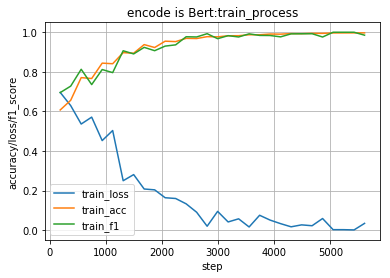

In [24]:
import matplotlib.pyplot as plt 
plt.plot(train_data[3],train_data[0],label='train_loss')
plt.plot(train_data[3],train_data[1],label='train_acc')
plt.plot(train_data[3],train_data[2],label='train_f1')
plt.legend()
plt.title('encode is '+parameters.encder+":train_process")
plt.ylabel('accuracy/loss/f1_score')
plt.xlabel('step')
#plt.ylim(0,1)
plt.grid()
plt.show()

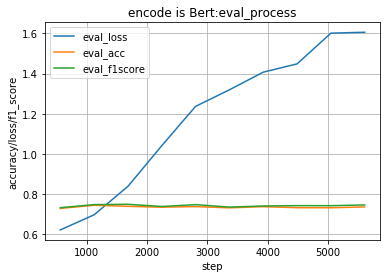

In [25]:
plt.plot(eval_data[3],eval_data[0],label='eval_loss')
plt.plot(eval_data[3],eval_data[1],label='eval_acc')
plt.plot(eval_data[3],eval_data[2],label='eval_f1score')
plt.legend()
plt.title('encode is '+parameters.encder+":eval_process")
plt.ylabel('accuracy/loss/f1_score')
plt.xlabel('step')
#plt.ylim(0,1)
plt.grid()
plt.show()

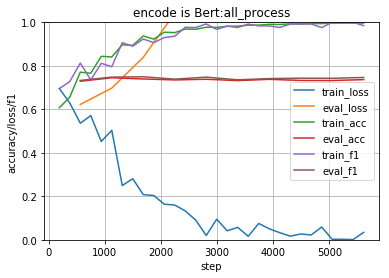

In [22]:
plt.plot(train_data[3],train_data[0],label='train_loss')
plt.plot(eval_data[3],eval_data[0],label='eval_loss')
plt.plot(train_data[3],train_data[1],label='train_acc')
plt.plot(eval_data[3],eval_data[1],label='eval_acc')
plt.plot(train_data[3],train_data[2],label='train_f1')
plt.plot(eval_data[3],eval_data[2],label='eval_f1')
plt.legend()
plt.title('encode is '+parameters.encder+":all_process")
plt.ylabel('accuracy/loss/f1')
plt.xlabel('step')
plt.ylim(0,1)
plt.grid()